In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

Activation Functions

In [168]:
# Heaviside step function 

def heavyside(x):
    if (x >= 0):
        return 1
    else :
        return 0
        
# Rectified error Linear Unit function

def relu(x):
    return max(0,x)

# Sigmoid function

def activation_sigmoid(t):
        return 1/(1+np.exp(-t))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(t):
    return np.exp(t)/np.sum(np.exp(t))

# Gassian error Linear Unit GeLU function

Neural Network

In [169]:
# Dataset
data = load_diabetes()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [262]:
class NeuralNetwork :

    def __init__(self):
        self.layers_wieghts = []
        self.layers_bias = []
        self.layers_activations = []  

    def activation_sigmoid(self, t):
        return 1/(1+np.exp(-t))

    def activation_sigmoid_derivative(self, t):
        return np.exp(-t)/(1+np.exp(-t))**2
    
    def activation_relu(self,t):
        return np.maximum(0,t)
    
    def activation_relu_derivative(self,t):
        return np.where(t <= 0, 0, 1)

    def activation_identity(self,t):
        return t
    
    def activation_identity_derivative(self,t):
        return 1

    def loss(self, X_train, y_train):
        y_hat = self.out(X_train)
        return mean_squared_error(y_hat, y_train)

    def loss_for_a_sample(self,x,y):
        y_hat = self.out(x)
        return np.mean((y_hat-y)**2)
                                  
    def integrate_layer(self,layer_index, x):
        out = self.layers_wieghts[layer_index]@x + self.layers_bias[layer_index]
        if (self.layers_activations[layer_index] == 's'):
            return  self.activation_sigmoid(out)
        elif (self.layers_activations[layer_index] == 'r'):
            return  self.activation_relu(out)
        elif (self.layers_activations[layer_index] == 'i'):
            return  self.activation_identity(out)
    
    def add_layer(self, layer_size, activation):

        if len(self.layers_activations) == 0:
            self.layers_wieghts.append(np.random.rand(layer_size, layer_size))
            self.layers_bias.append(np.random.rand(layer_size))
            self.layers_activations.append(activation)
        else :
            self.layers_wieghts.append(np.random.rand(layer_size, len(self.layers_bias[-1])))
            self.layers_bias.append(np.random.rand(layer_size))
            self.layers_activations.append(activation)
        
    def update_weights(self, layer_index, delta_w):
        self.layers_wieghts[layer_index]  = self.layers_wieghts[layer_index]  + delta_w

    def update_bias(self, layer_index, delta_b):
        self.layers_bias[layer_index]  = self.layers_bias[layer_index] + delta_b 

    def delete_layer(self):
        if len(self.layers) > 1:
            self.layers.pop()
        else :
            print("No Hidden Layers to delete")

    def derivative_of_activation_step(self,E, layer_index):
        if self.layers_activations[layer_index] == 's':
            return self.activation_sigmoid_derivative(E)
        elif self.layers_activations[layer_index] == 'r':
            return self.activation_relu_derivative(E)
        elif self.layers_activations[layer_index] == 'i':
            return self.activation_identity_derivative(E)

    def backward(self, X_, y_, alpha):
        activations = self.get_activations(X_)
        l = len(self.layers_bias)

        # Initiating with Output Layer
        E_d = activations[l-1] - y_
        E_d = E_d*self.derivative_of_activation_step(E_d, l-1)
        delta_w = -(alpha/len(E_d))*2* E_d @ activations[l-2].T.reshape(-1, len(activations[l-2]))
        delta_b = -(alpha/len(E_d))*2* E_d
        delta_a_l = -alpha*2*E_d @ self.layers_wieghts[l-1]
        delta_a_l = delta_a_l*self.derivative_of_activation_step(delta_a_l,l-1)
        self.update_weights(l-1, delta_w)
        self.update_bias(l-1, delta_b)
        # print(activations)
        # print("\n")
        
        # Hidden Layers
        for i in range(l-2,0,-1):
            delta_w = -((alpha/len(delta_a_l))*2* delta_a_l).reshape(len(delta_a_l),1) @ activations[i-1].T.reshape(-1, len(activations[i-1]))
            delta_b = -(alpha/len(delta_a_l))*2* delta_a_l
            self.update_weights(i, delta_w)
            self.update_bias(i, delta_b)
            delta_a_l = -(alpha/len(delta_a_l))*2*delta_a_l @ self.layers_wieghts[i]
            delta_a_l = delta_a_l*self.derivative_of_activation_step(delta_a_l,i)
        
        # Input Layer
        delta_w = -(alpha/len(delta_a_l))*2* delta_a_l.reshape(len(delta_a_l),1) @ X_.T.reshape(-1,len(X_))
        delta_b = -(alpha/len(delta_a_l))*2* delta_a_l
        self.update_weights(0, delta_w)
        self.update_bias(0, delta_b)
    
    def get_activations(self, X_):
        l = len(self.layers_bias)
        activations = []
        previous_out = self.integrate_layer(0, X_).copy()
        activations.append(previous_out)
        for i in range(1,l):
            current_out = self.integrate_layer(i,previous_out).copy()
            previous_out = current_out.copy()
            activations.append(previous_out)
        return activations

    def forward(self, X_):
        l = len(self.layers_bias)
        previous_out = self.integrate_layer(0, X_).copy()
        for i in range(1,l):
            current_out = self.integrate_layer(i,previous_out).copy()
            previous_out = current_out.copy()
        return previous_out
    
    def train(self,alpha, X_train, y_train):
        max_epochs = 1000
        for e in range(max_epochs):
            # out = self.predict(X_train)
            # print(mean_squared_error(out,y_train),out[0])
            for i in range(len(X_train)):
                self.backward(X_train[i],y_train[i],alpha)
            
    def predict(self, X_test):
        n = len(X_test)
        m = len(self.layers_bias[-1])
        prediction = np.empty((n,m))
        for i in range(n):
            out = self.forward(X_test[i])
            for j in range(m):
                prediction[i][j] = out[j]
        return prediction
    

In [263]:
nn = NeuralNetwork()
nn.add_layer(10,'r')
nn.add_layer(1,'i')

In [264]:
nn.forward(X_train[4])

array([1.82703691])

In [265]:
nn.train(0.0001, X_train, y_train) 

In [266]:
y_hat = nn.predict(X_test)

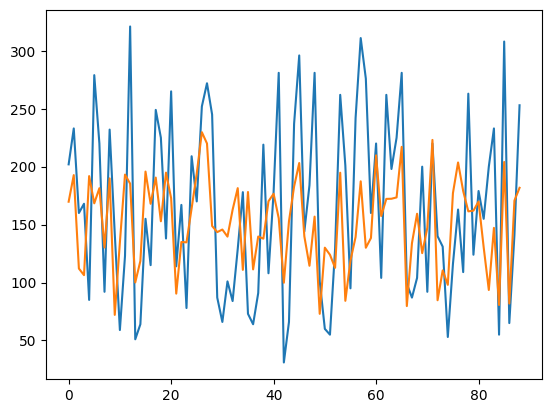

In [267]:
# Plotting
sr = np.arange(len(y_test))
plt.plot(sr,y_test)
plt.plot(sr,y_hat)
plt.show()

In [268]:
mean_squared_error(y_hat, y_test)

4561.425389155259

PyTorch Implementation

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset
data = load_diabetes()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test= torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Model
model = nn.Sequential(
    nn.Linear(10, 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)
print(model)
 
# train the model
loss_fn   = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 100
batch_size = 10
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Sequential(
  (0): Linear(in_features=10, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)
Finished epoch 0, latest loss 15425.2607421875
Finished epoch 1, latest loss 15396.0947265625
Finished epoch 2, latest loss 15352.3828125
Finished epoch 3, latest loss 15282.2841796875
Finished epoch 4, latest loss 15173.4423828125
Finished epoch 5, latest loss 15013.1005859375
Finished epoch 6, latest loss 14789.85546875
Finished epoch 7, latest loss 14494.30078125
Finished epoch 8, latest loss 14119.3955078125
Finished epoch 9, latest loss 13660.8203125
Finished epoch 10, latest loss 13117.3359375
Finished epoch 11, latest loss 12488.9013671875
Finished epoch 12, latest loss 11742.671875
Finished epoch 13, latest loss 10890.6767578125
Finished epoch 14, latest loss 9963.0146484375
Finished epoch 15, latest loss 8988.3427734375
Finished epoch 16, latest loss 7996.70751953125


In [155]:
y_hat = model(X_test)

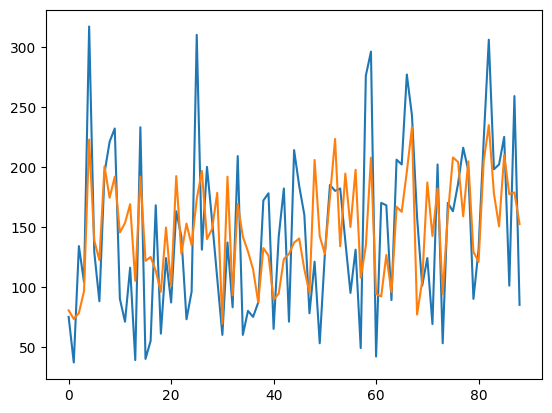

In [156]:
# Plotting
sr = np.arange(len(y_test))
plt.plot(sr, np.array(y_test))
plt.plot(sr,y_hat.detach().numpy())
plt.show()